# 猫狗图像识别实践

图像识别技术可以识别出图像或者视频中的物体类别。本实验基于猫狗数据集，使用Keras手动搭建一个经典的VGG16卷积神经网络，训练一个猫狗分类模型。

## 数据集

猫狗识别数据集，猫和狗各12500张图片，图片名称中含有类别名称（cat和dog）。我们会根据图片名称中包含的类别名称（cat或dog）给图片打标签，狗的标签打成1，猫的标签打成0。

## 实践步骤

### 进入ModelArts

点击如下链接：https://www.huaweicloud.com/product/modelarts.html ， 进入ModelArts主页。点击“立即使用”按钮，输入用户名和密码登录，进入ModelArts使用页面。

### 创建ModelArts notebook

下面，我们在ModelArts中创建一个notebook开发环境，ModelArts notebook提供网页版的Python开发环境，可以方便的编写、运行代码，并查看运行结果。

第一步：在ModelArts服务主界面依次点击“开发环境”、“创建”

![create_nb_create_button](./img/create_nb_create_button.png)

第二步：填写notebook所需的参数：

| 参数 | 说明 |
| - - - - - | - - - - - |
| 计费方式 | 按需计费  |
| 名称 | Notebook实例名称，如 image_recognition |
| 工作环境 | Python3 |
| 资源池 | 选择"公共资源池"即可 |
| 类型 | 本案例使用较为复杂的深度神经网络模型，需要较高算力，选择"GPU" |
| 规格 | 选择"8核 &#124; 64GiB &#124; 1*p100" |
| 存储配置 | 选择EVS，磁盘规格5GB |

第三步：配置好notebook参数后，点击下一步，进入notebook信息预览。确认无误后，点击“立即创建”

![create_nb_creation_summary](./img/create_nb_creation_summary.png)

第四步：创建完成后，返回开发环境主界面，等待Notebook创建完毕后，打开Notebook，进行下一步操作。
![modelarts_notebook_index](./img/modelarts_notebook_index.png)

### 在ModelArts中创建开发环境

接下来，我们创建一个实际的开发环境，用于后续的实验步骤。

第一步：点击下图所示的“打开”按钮，进入刚刚创建的Notebook
![inter_dev_env](img/enter_dev_env.png)

第二步：创建一个Python3环境的的Notebook。点击右上角的"New"，然后创建TensorFlow 1.13.1开发环境。

第三步：点击左上方的文件名"Untitled"，并输入一个与本实验相关的名称，如"image_recognition"
![notebook_untitled_filename](./img/notebook_untitled_filename.png)
![notebook_name_the_ipynb](./img/notebook_name_the_ipynb.png)


### 在Notebook中编写并执行代码

在Notebook中，我们输入一个简单的打印语句，然后点击上方的运行按钮，可以查看语句执行的结果：
![run_helloworld](./img/run_helloworld.png)


开发环境准备好啦，接下来可以愉快地写代码啦！

### 升级依赖

In [1]:
!pip install --upgrade keras_applications==1.0.6 keras==2.2.4

    100% |████████████████████████████████| 51kB 66.3MB/s ta 0:00:01
    100% |████████████████████████████████| 317kB 103.8MB/s ta 0:00:01
    100% |████████████████████████████████| 2.8MB 63.4MB/s ta 0:00:01101
    100% |████████████████████████████████| 20.4MB 53.5MB/s ta 0:00:011MB 93.5MB/s eta 0:00:01�█████████▊                     | 6.8MB 89.5MB/s eta 0:00:01████████▉              | 11.4MB 94.1MB/s eta 0:00:01MB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 80.0MB/s ta 0:00:01
    100% |████████████████████████████████| 266kB 102.7MB/s ta 0:00:01��        | 194kB 105.1MB/s eta 0:00:01
    100% |████████████████████████████████| 25.2MB 90.6MB/s ta 0:00:011        | 5.8MB 99.6MB/s eta 0:00:01                   | 9.2MB 105.4MB/s eta 0:00:01�███▍               | 12.9MB 100.2MB/s eta 0:00:01�██████████▏     | 20.6MB 101.8MB/s eta 0:00:01��████ | 24.5MB 104.3MB/s eta 0:00:01
  Running setup.py bdist_wheel for pyyaml ... done
  Stored in directory: /home/ma-user/.cache/

### 导入依赖库

In [2]:
import os, cv2, random
import numpy as np

# 画图工具
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.callbacks import Callback, EarlyStopping, TensorBoard
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras import backend as K
K.set_image_data_format('channels_last') # 数据格式data_format设置为 NHWC

Using TensorFlow backend.
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

### 下载数据集

下载数据压缩包，解压，然后清理压缩包。

In [3]:
from modelarts.session import Session
session = Session()

if session.region_name == 'cn-north-1':
    bucket_path="modelarts-labs/notebook/DL_image_recognition/image_recognition.tar.gz"
elif session.region_name == 'cn-north-4':
    bucket_path="modelarts-labs-bj4/notebook/DL_image_recognition/image_recognition.tar.gz"
else:
    print("请更换地区到北京一或北京四")

In [4]:
if not os.path.exists('./data'):
    session.download_data(
    bucket_path= bucket_path,
    path="./image_recognition.tar.gz")

    # 使用tar命令解压资源包
    !tar xf ./image_recognition.tar.gz

    # 清理压缩包
    !rm -f ./image_recognition.tar.gz

Successfully download file modelarts-labs/notebook/DL_image_recognition/image_recognition.tar.gz from OBS to local ./image_recognition.tar.gz


### 读取数据集

读取数据集，并把图像resize到 128 * 128 大小。

In [5]:
DATA_DIR = './data/' # 数据集路径

# 目标缩放尺寸
ROWS = 128
COLS = 128
CHANNELS = 3

image_file_names = [DATA_DIR+i for i in os.listdir(DATA_DIR)] 
dogs = [DATA_DIR+i for i in os.listdir(DATA_DIR) if 'dog' in i]
cats = [DATA_DIR+i for i in os.listdir(DATA_DIR) if 'cat' in i]

# 数据洗牌
random.shuffle(image_file_names)

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) # 彩色模式读取图像
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prep_data(image_file_names):
    count = len(image_file_names)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)
    
    for i, image_file in enumerate(image_file_names):
        image = read_image(image_file)
        data[i] = image
        if i%1000 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

# 读取图片至内存
images = prep_data(image_file_names)

Processed 0 of 25000
Processed 1000 of 25000
Processed 2000 of 25000
Processed 3000 of 25000
Processed 4000 of 25000
Processed 5000 of 25000
Processed 6000 of 25000
Processed 7000 of 25000
Processed 8000 of 25000
Processed 9000 of 25000
Processed 10000 of 25000
Processed 11000 of 25000
Processed 12000 of 25000
Processed 13000 of 25000
Processed 14000 of 25000
Processed 15000 of 25000
Processed 16000 of 25000
Processed 17000 of 25000
Processed 18000 of 25000
Processed 19000 of 25000
Processed 20000 of 25000
Processed 21000 of 25000
Processed 22000 of 25000
Processed 23000 of 25000
Processed 24000 of 25000


### 给图片打标签

我们根据图片名称包含的字符串给图片打标签。我们用0表示cat，1表示dog。

In [6]:
num_train_samples = len(image_file_names)
num_classes = 2 # 类别数是2
labels = []

index = 0
for filename in image_file_names:
    if 'dog' in filename:
        labels.append(1)
    elif 'cat' in filename:
        labels.append(0)
        
# 把类别标签转换为onehot编码
labels = np_utils.to_categorical(labels, num_classes)

### 切分数据集

（train_data，train_label）是训练数据，（test_data，test_label）是测试数据。测试数据占25%。

In [7]:
train_data, test_data, train_label, test_label = train_test_split(images, labels, test_size=0.25, random_state=10)

### 查看猫狗的样本图片

这些图片是经过尺寸调整后的图片

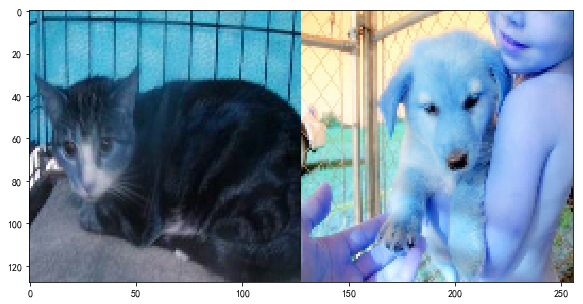

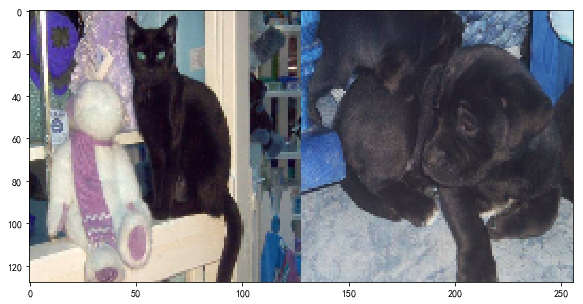

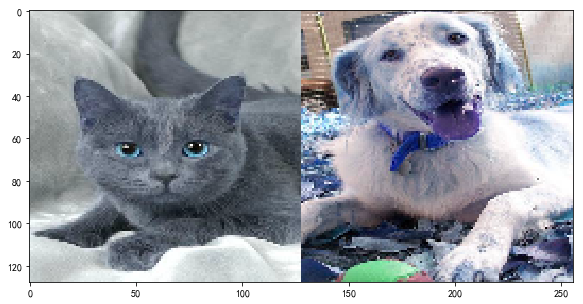

In [8]:
def show_cats_and_dogs(idx):
    cat = read_image(cats[idx])
    dog = read_image(dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,3):
    show_cats_and_dogs(idx)

### 构建神经网络

Keras是一个非常简单易用的，适合新手入门的深度学习引擎。接下来，我们使用Keras搭建一个VGG16卷积神经网络。

#### 设置超参

In [9]:
batch_size = 32 # 批大小
learning_rate = 1e-5 # 设置学习率为1e-5

#### 设置优化器

In [10]:
optimizer = Adam(lr=learning_rate) # 优化器使用 Adam 

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


In [11]:
objective = 'categorical_crossentropy' # loss 函数使用交叉熵

def load_model():
    # 这是一个模型参数随机初始化的模型，如果想要加载imagenet预训练模型，可以设置 weights='imagenet'
    base_model = VGG16(include_top=False, weights=None, input_shape=(ROWS, COLS, CHANNELS), pooling='avg')

    x = base_model.output
    
    # 修改base_model的模型输出层。这是一个二分类的问题。
    prediction_layer = Dense(2, activation='softmax')(x)
    
    # 组装成新的模型
    model = Model(inputs=base_model.input, outputs=prediction_layer)
    
    # 模型编译
    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model

model = load_model()

### 模型结构概览

可以查看到刚刚搭建的神经网络结构的详情。

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

### 模型训练

在模型训练过程中，为了防止过拟合，我们使用了early stopping策略，当val_loss在连续3个epoch不再减少的情况下，就停止训练。

本案例训练15轮，大概耗费10分钟。

可以看到训练日志输出，其中会打印Loss（损失函数）和acc（精确度）信息。

In [13]:
epochs = 15 # 训练轮数

# early stopping策略
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')   

def run_train():
    
    # 开始训练
    history = model.fit(
        train_data, 
        train_label, 
        batch_size=batch_size, 
        epochs=epochs,
        validation_split=0.2,  # 训练数据中，抽取20%的数据作为验证数据
        verbose=1,
        shuffle=True,
        callbacks=[early_stopping]) 
    return history

history = run_train()

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Train on 15000 samples, validate on 3750 samples
Epoch 1/15
15000/15000 [==============================] - 55s 4ms/step - loss: 0.6479 - acc: 0.6143 - val_loss: 0.6114 - val_acc: 0.6568
Epoch 2/15
15000/15000 [==============================] - 42s 3ms/step - loss: 0.5777 - acc: 0.6876 - val_loss: 0.5675 - val_acc: 0.7008
Epoch 3/15
15000/15000 [==============================] - 42s 3ms/step - loss: 0.5205 - acc: 0.7369 - val_loss: 0.5278 - val_acc: 0.7400
Epoch 4/15
15000/15000 [==============================] - 42s 3ms/step - loss: 0.4730 - acc: 0.7711 - val_loss: 0.4614 - val_acc: 0.7821
Epoch 5/15
15000/15000 [==============================] - 42s 3ms/step - loss: 0.4326 - acc: 0.7993 - val_loss: 0.4204 - val_acc: 0.8003
Epoch 6/15
15000/15000 [==============================] - 42s 3ms/step - loss: 0.3972 - acc: 0.8228 - val_loss: 0.4064 - val_acc: 0.8160
Epoch 7/15
15000/15000 [==============================] - 42s 3ms/step - loss: 0.3642 - acc: 0.8397 - val_loss: 0.4178 - val_acc:

### 保存模型

训练好的模型可以保存起来，永久使用。

In [14]:
OUTPUT = 'output'

if not os.path.exists(OUTPUT):
    os.mkdir(OUTPUT)

model.save(os.path.join(OUTPUT, 'model.h5'))

### 可视化训练过程

将Loss随epoch的变化趋势使用折线图展示

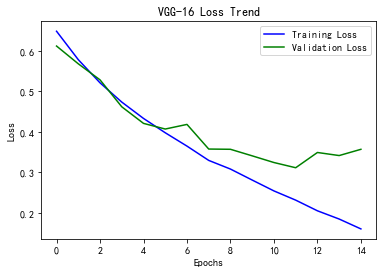

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0, epochs)[0::2])
plt.legend()
plt.show()

将accurary随epoch的变化趋势使用折线图展示

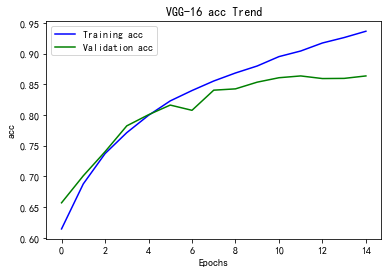

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.xlabel('Epochs')
plt.ylabel('acc')
plt.title('VGG-16 acc Trend')
plt.plot(acc, 'blue', label='Training acc')
plt.plot(val_acc, 'green', label='Validation acc')
plt.xticks(range(0, epochs)[0::2])
plt.legend()
plt.show()

### 样本数据预测

预测测试集

In [17]:
predictions = model.predict(test_data, verbose=0)

直观展示10个样本数据的预测结果

I am 100.00% sure this is a Cat


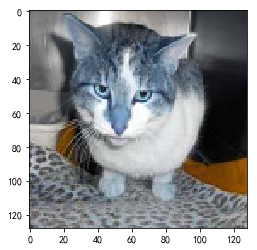

I am 97.95% sure this is a Dog


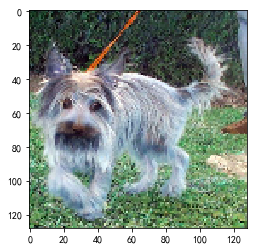

I am 100.00% sure this is a Cat


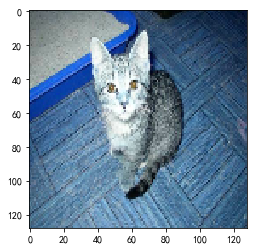

I am 99.80% sure this is a Dog


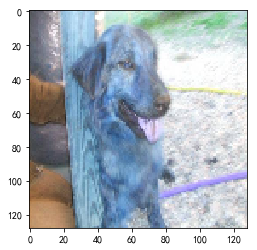

I am 98.51% sure this is a Cat


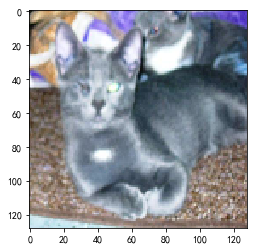

I am 72.42% sure this is a Cat


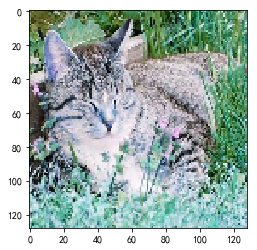

I am 85.81% sure this is a Cat


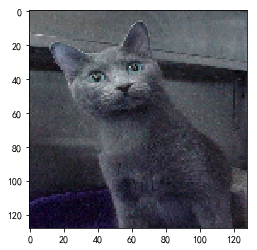

I am 93.21% sure this is a Dog


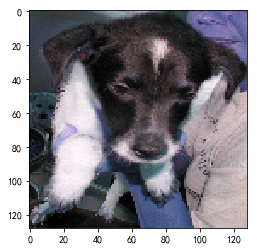

I am 99.75% sure this is a Cat


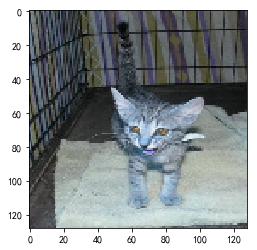

I am 95.61% sure this is a Cat


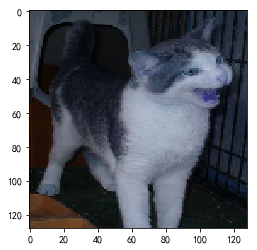

In [18]:
for i in range(0,10):
    p = predictions[i]
    
    if round(p[1]) == 1: 
        print('I am {:.2%} sure this is a Dog'.format(p[1]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1 - p[1]))
        
    plt.imshow(test_data[i])
    plt.show()

### 评估模型准确度

通过测试集的预测结果，计算模型的准确度。

In [19]:
predictions_test_array = []
test_label_array = []

# 将onehot编码的数据进行格式转换
for p in predictions:
    if round(p[1]) == 1:
        predictions_test_array.append(1)
    else:
        predictions_test_array.append(0)
        
for t in test_label:
    if int(t[1]) == 1:
        test_label_array.append(1)
    else:
        test_label_array.append(0)
        
acc = accuracy_score(test_label_array, predictions_test_array)

print('训练得到的猫狗识别模型的准确度是：%f' % acc)

训练得到的猫狗识别模型的准确度是：0.870240


## 小结

本实验使用Keras搭建了一个VGG16神经网络，并使用猫狗数据集训练了一个猫狗识别模型。

## 友情提示

完成实验后，可以停止notebook，否则会继续扣费。notebook停止后，不会删除ipynb文件，notebook重新启动后，ipynb文件仍然存在。